In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

def poisson_random_process(lmbda, total_time):
    """
    Generate a Poisson random process.
    
    Parameters:
        lmbda (float): The parameter lambda of the Poisson distribution.
        total_time (float): The total time for the process.
    
    Returns:
        numpy.ndarray: An array of timestamps when events occur.
    """
    num_events = np.random.poisson(lmbda * total_time)
    event_times = np.cumsum(np.random.exponential(1 / lmbda, num_events))
    event_times = event_times[event_times < total_time]
    return event_times



# scheme 1: one heralding signal

In [51]:
loss_switch = 10**(-0.1*0.5)
trans = lambda t: 10**(-0.02*2e5*t)

gen_rate = 1e6 # Parameter lambda in Hz
total_time_list = np.logspace(-5,-2,10)  # Total time in sec for the process
fdl_list = 10**np.arange(-4,2.1,1)*1e-9  # delay line time quantization in sec
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = [2e-10]#np.arange(.2,1.1,.4)*1e-9 

Nrep = 2000
succ_rate = np.zeros((len(total_time_list),len(tolerance_list),len(fdl_list), Nrep))
for i_t, total_time in enumerate(total_time_list):
    tic = time.time()
    for i_th, tolerance in enumerate(tolerance_list):
        # print(i_t, end="\r")
        for i_f, fdl in enumerate(fdl_list):
            for i_r in range(Nrep):
                # print(i_r, end="\r")
                s1 = poisson_random_process(gen_rate, total_time)
                s2 = poisson_random_process(gen_rate, total_time)
                if len(s1)*len(s2)==0:
                    continue
                num_trials = min(s1.shape[0],s2.shape[0])
                # num_trials
                all_events = np.concatenate((s1,s2))
                events_inds = all_events.argsort()
                all_events = all_events[events_inds]
                emissions = np.zeros(events_inds.shape[0])
                emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

                i1 = 0
                photon1 = emissions[i1]
                # coincident_counter = 0
                for i_trial in range(num_trials):
                    next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
                    if len(next_event)>0:
                        i2 = i1+ next_event[0,0] +1 
                        photon2 = emissions[i2]
                        dt = all_events[i2]-all_events[i1]
                        assert dt>0
                        dt_detector = dt-(dt//fdl+1)*fdl
                        if abs(dt_detector) < tolerance:
                            prob = loss_switch**(dt//fdl)*trans((dt//fdl+1)*fdl)
                            if np.random.rand()< prob: # accept with probability p
                                succ_rate[i_t,i_th,i_f,i_r] += 1
                                break                                
                        i1 = i2 + 1
                        if i1 < len(emissions):
                            photon1 = emissions[i1]
                        else:
                            break
                    else:
                        break
                    
    toc = time.time()
    print(f"({i_t}), elapsed time {toc-tic} sec")

# succ_rate /= Nrep
# print(trans_prob.mean(axis=2))

(0), elapsed time 1.136561632156372 sec
(1), elapsed time 2.0942912101745605 sec
(2), elapsed time 4.1690428256988525 sec
(3), elapsed time 8.563971757888794 sec
(4), elapsed time 18.52833890914917 sec
(5), elapsed time 40.57447671890259 sec
(6), elapsed time 87.49896597862244 sec
(7), elapsed time 197.57933855056763 sec
(8), elapsed time 572.4637520313263 sec
(9), elapsed time 1939.1226077079773 sec


In [60]:
fname = f"results/prob_vs_timeslot_tol_{tolerance*1e9:.2f}_method_1.npz"
np.savez(fname,gen_rate, total_time_list,
         fdl_list,tolerance_list,
         succ_rate,trans_prob)

In [2]:
fname = f"results/rates_vs_delay_w_loss_dense.npz"
f1 = np.load(fname)
gen_rate = f1['arr_0'] 
total_time = f1['arr_1'] 
fdl_list =  f1['arr_2'] 
tolerance_list = f1['arr_3'] 
succ_rate = f1['arr_4'] 
trans_prob = f1['arr_5'] 


fname_base = f"results/rates_baseline.npz"
f2 = np.load(fname_base)
# tolerance_list = f2['arr_2'] 
succ_rate_base = f2['arr_3'] 


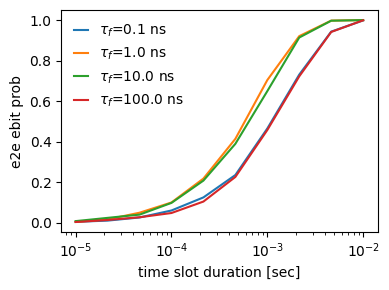

In [64]:
plt.figure(figsize=(4,3))
for i_f, fdl in enumerate(fdl_list):
    if i_f >= 3:
        if fdl*1e9<.1:
            plt.plot(total_time_list, (succ_rate[:,0,i_f,:]).mean(axis=-1), "-",markersize=2, color = f"C{i_f-3}", label=fr"$\tau_f$={fdl*1e9:.4f} ns")
        else:
            plt.plot(total_time_list, (succ_rate[:,0,i_f,:]).mean(axis=-1), "-",markersize=2, color = f"C{i_f-3}", label=fr"$\tau_f$={fdl*1e9:.1f} ns")

plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"time slot duration [sec]")
plt.ylabel("e2e ebit prob")
# plt.ylim([1e1,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_baseline.pdf")
# plt.savefig("figures/rate_vs_delay_w_loss_dense.pdf")
# plt.savefig("figures/rate_vs_delay_baseline.pdf")
plt.show()


## baseline

In [12]:
gen_rate = 1e6 # Parameter lambda in Hz
total_time = 1e-3  # Total time in sec for the process
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = np.arange(.2,1.1,.2)*1e-9 

Nrep = 3000
succ_rate_base = np.zeros((len(tolerance_list), Nrep))
for i_t, tolerance in enumerate(tolerance_list):
    # print(i_t, end="\r")
    tic = time.time()
    for i_r in range(Nrep):
        # print(i_r, end="\r")
        s1 = poisson_random_process(gen_rate, total_time)
        s2 = poisson_random_process(gen_rate, total_time)

        num_trials = min(s1.shape[0],s2.shape[0])
        # num_trials
        all_events = np.concatenate((s1,s2))
        events_inds = all_events.argsort()
        all_events = all_events[events_inds]
        emissions = np.zeros(events_inds.shape[0])
        emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

        coincident_events = []
        coincident_inds = []
        time_diff = []
        accepted_ids = []

        i1 = 0
        photon1 = emissions[i1]
        # coincident_counter = 0
        for i_trial in range(num_trials):
            next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
            if len(next_event)>0:
                i2 = i1+ next_event[0,0] +1 
                photon2 = emissions[i2]
                dt = all_events[i2]-all_events[i2-1]
                time_diff.append(dt)
                assert dt>0
                coincident_inds.append((i1,i2))
                coincident_events.append(emissions[[i1,i2]].tolist())

                i1 = i2 + 1
                if i1 < len(emissions):
                    photon1 = emissions[i1]
                else:
                    break
            else:
                break
            
        time_diff = np.array(time_diff)
        accepted_ids = np.argwhere(time_diff< tolerance)[:,0]
        succ_rate_base[i_t,i_r] = accepted_ids.shape[0]/total_time

    toc = time.time()
    print(f"{i_t}, elapsed time {toc-tic} sec")

# succ_rate /= Nrep
# print(trans_prob.mean(axis=2))

0, elapsed time 22.258883953094482 sec
1, elapsed time 22.317538022994995 sec
2, elapsed time 22.141185998916626 sec
3, elapsed time 22.25410008430481 sec
4, elapsed time 22.213851928710938 sec


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


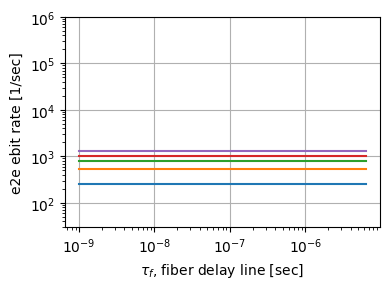

In [14]:
plt.figure(figsize=(4,3))
for i_t, tolerance in enumerate(tolerance_list):
    # plt.errorbar(fdl_list, (succ_rate[i_t,:,:]*trans_prob[i_t,:,:]).mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")
    plt.plot(fdl_list,fdl_list*0+ (succ_rate[i_t,:]).mean(), "-", color = f"C{i_t}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau_f$, fiber delay line [sec]")
plt.ylabel("e2e ebit rate [1/sec]")
plt.ylim([3e1,1e6])
plt.legend(frameon=False, handlelength=1)
plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_zoomed.pdf")
plt.show()


In [15]:
fname = f"results/rates_baseline.npz"
np.savez(fname,gen_rate, total_time,
         tolerance_list,
         succ_rate)

# two FDL scheme

In [43]:
loss_switch = 10**(-0.1*0.5)
trans = lambda t: 10**(-0.02*2e5*t)

gen_rate = 1e6 # Parameter lambda in Hz
total_time_list = np.logspace(-5,-2,10)  # Total time in sec for the process
fdl_list = 10**np.arange(-4,2.1,1)*1e-9  # delay line time quantization in sec
# tolerance_list = np.logspace(-10,-8,4) 
tolerance_list = [2e-10]#np.arange(.2,1.1,.4)*1e-9 

Nrep = 2000
succ_rate = np.zeros((len(total_time_list),len(tolerance_list),len(fdl_list), Nrep))
for i_t, total_time in enumerate(total_time_list):
    tic = time.time()
    for i_th, tolerance in enumerate(tolerance_list):
        # print(i_t, end="\r")
        for i_f, fdl in enumerate(fdl_list):
            for i_r in range(Nrep):
                # print(i_r, end="\r")
                s1 = poisson_random_process(gen_rate, total_time)
                s2 = poisson_random_process(gen_rate, total_time)
                if len(s1)*len(s2)==0:
                    continue
                num_trials = min(s1.shape[0],s2.shape[0])
                # num_trials
                all_events = np.concatenate((s1,s2))
                events_inds = all_events.argsort()
                all_events = all_events[events_inds]
                emissions = np.zeros(events_inds.shape[0])
                emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

                i1 = 0
                photon1 = emissions[i1]
                # coincident_counter = 0
                for i_trial in range(num_trials):
                    next_event = np.argwhere(emissions[i1+1:]== 1- photon1)
                    if len(next_event)>0:
                        i2 = i1+ next_event[0,0] +1 
                        photon2 = emissions[i2]
                        dt = all_events[i2]-all_events[i1]
                        assert dt>0
                        dt_detector = dt-(dt//fdl)*fdl
                        if min(abs(dt_detector),abs(fdl-dt_detector)) < tolerance:
                            if abs(dt_detector)>abs(fdl-dt_detector):
                                prob = loss_switch**(dt//fdl)*trans((dt//fdl+1)*fdl)
                            else:
                                prob = loss_switch**(dt//fdl)*trans((dt//fdl+2)*fdl)
                            if np.random.rand()< prob: # accept with probability p
                                succ_rate[i_t,i_th,i_f,i_r] += 1
                                break 
                              
                        i1 = i2 + 1
                        if i1 < len(emissions):
                            photon1 = emissions[i1]
                        else:
                            break
                    else:
                        break
                    
    toc = time.time()
    print(f"({i_t}), elapsed time {toc-tic} sec")

# print(trans_prob.mean(axis=2))

(0), elapsed time 1.1974966526031494 sec
(1), elapsed time 2.145395517349243 sec
(2), elapsed time 4.318615198135376 sec
(3), elapsed time 9.000543355941772 sec
(4), elapsed time 19.29288101196289 sec
(5), elapsed time 40.78716516494751 sec
(6), elapsed time 85.05889797210693 sec
(7), elapsed time 188.6819019317627 sec
(8), elapsed time 542.9012651443481 sec
(9), elapsed time 1846.7306146621704 sec


In [44]:
fname = f"results/prob_vs_timeslot_tol_{tolerance*1e9:.2f}_method_2.npz"
np.savez(fname,gen_rate, total_time_list,
         fdl_list,tolerance_list,
         succ_rate,trans_prob)

In [4]:
fname = f"results/prob_vs_timeslot_tol_{tolerance*1e9:.2f}_method_2.npz"
f1 = np.load(fname)
gen_rate = f1['arr_0'] 
total_time = f1['arr_1'] 
fdl_list =  f1['arr_2'] 
tolerance_list = f1['arr_3'] 
succ_rate = f1['arr_4'] 
trans_prob = f1['arr_5'] 


fname_base = f"results/rates_baseline.npz"
f2 = np.load(fname_base)
# tolerance_list = f2['arr_2'] 
succ_rate_base = f2['arr_3'] 


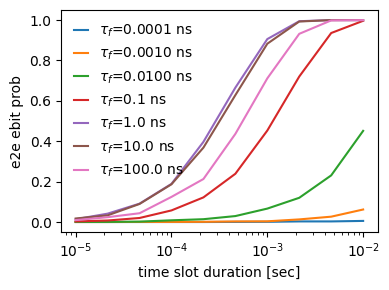

In [50]:
plt.figure(figsize=(4,3))
for i_f, fdl in enumerate(fdl_list):
    # plt.errorbar(fdl_list, (succ_rate[i_t,:,:]*trans_prob[i_t,:,:]).mean(axis=1), succ_rate[i_t,:,:].std(axis=1)/Nrep**0.5, fmt=".-", capsize=2, color = f"C{i_t}", label=fr"$\tau_w$ = {tolerance*1e9:.2f} ns")
    if fdl*1e9<.1:
        plt.plot(total_time_list, (succ_rate[:,0,i_f,:]).mean(axis=-1), "-",markersize=2, color = f"C{i_f}", label=fr"$\tau_f$={fdl*1e9:.4f} ns")
    else:
        plt.plot(total_time_list, (succ_rate[:,0,i_f,:]).mean(axis=-1), "-",markersize=2, color = f"C{i_f}", label=fr"$\tau_f$={fdl*1e9:.1f} ns")
    # plt.plot(fdl_list, fdl_list*0 + succ_rate_base[i_t,:].mean(), ":",markersize=3, color = f"C{i_t}")

plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"time slot duration [sec]")
plt.ylabel("e2e ebit prob")
# plt.ylim([1e1,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
# plt.savefig("figures/rate_vs_delay_w_loss_baseline.pdf")
# plt.savefig("figures/rate_vs_delay_w_loss_dense.pdf")
# plt.savefig("figures/rate_vs_delay_baseline.pdf")
plt.show()


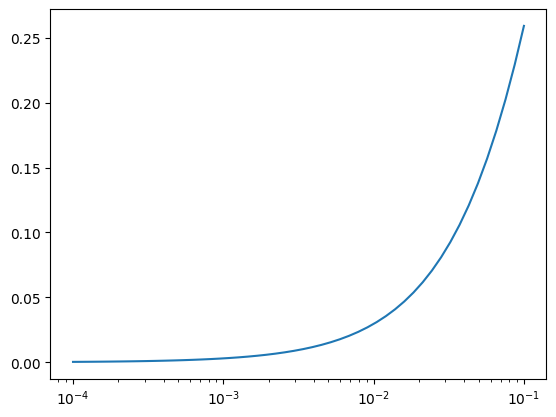

In [7]:
x = np.logspace(-4,-1)
rate = 3*1e0
y = 1-np.exp(-rate*x)
plt.plot(x,y)
plt.xscale("log")